<a href="https://colab.research.google.com/github/Lucas-GomezP/Proyecto3-BigData-UPSO/blob/main/Laboratorio_3_BigData_UPSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción

En el laboratorio, nos centraremos en un conjunto de datos que incluye registros de crímenes de 1973 en distintos estados de EE. UU., así como el porcentaje de la población que reside en zonas urbanas en esos estados. El propósito es clasificar los estados en diferentes categorías basadas en estos factores.

---

### Conjunto de datos
Crímenes:
* Asesinatos: La tasa de asesinatos, que se suele calcular como el número de
asesinatos por cada 100,000 habitantes en el estado.
* Asaltos: La tasa de asaltos, que también se calcula por cada 100,000 habitantes. Esto incluiría casos de ataques violentos, incluyendo agresiones físicas.
* Población Urbana: El porcentaje de la población que vive en áreas urbanas del
estado. Un número más alto indica una mayor concentración de población en las
ciudades.
* Violaciónes: La tasa de violaciones, similarmente calculada por cada 100,000
habitantes. Representa la incidencia de este tipo de crimen en el estado

---

### Tarea a desarrollar
Se debe desarrollar un programa que permita clasificar los estados en diferentes categorías, dividiéndolos en zonas de baja peligrosidad y alta peligrosidad. Este proyecto debe ser ejecutado en un Notebook de Colab.

No es necesario aplicar múltiples modelos de clustering, ¡con aplicar uno de ellos está más que bien!

Dentro del Notebook, es importante que cada paso del proceso esté acompañado por
bloques de texto que expliquen el razonamiento detrás de las decisiones tomadas. Se debe detallar por qué se eligieron ciertas técnicas, métodos o parámetros y cuál es su relevancia en el contexto del proyecto. Además, es necesario documentar los desafíos o inconvenientes que surgieron durante el desarrollo, proporcionando una visión clara y completa del proceso de diseño e implementación de la solución.

---

### Fecha de entrega: Miércoles, 20 de Noviembre, 23:00 hs

# Integrantes
* Huck, Gabriel
* Grosso, Alejandro
* Gomez Peña, Lucas

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Analisis exploratorio

In [131]:
df = pd.read_csv("/content/drive/MyDrive/Materias/Big Data/practico 3/Crimenes.csv").copy()
df.head()

,Estado,Asesinatos,Asaltos,Poblacion Urbana,Violaciones
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


Lo que podemos observar a continuacion es la informacion de nuestro dataset, pero para hacer nuestro clustering debemos solo tener variables numericas por lo que pondremos los nombres de estados como indices

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Estado            50 non-null     object 
 1   Asesinatos        50 non-null     float64
 2   Asaltos           50 non-null     int64  
 3   Poblacion Urbana  50 non-null     int64  
 4   Violaciones       50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [133]:
df_normalizado = df.copy()

df_normalizado.index = df_normalizado.iloc[:,0]
df_normalizado = df_normalizado.iloc[:,1:5]
df_normalizado.head()

,Asesinatos,Asaltos,Poblacion Urbana,Violaciones
Estado,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Lo que podemos observar a continuacion es una gran disparidad entre los promedios de nuestras caracteristicas, ya que por ejemplo en asesinatos tenemos 7.7 mientras que en asaltos tenemos 170, por lo que vamos a normalizar estos valores para obtener mejores resultados

In [134]:
df_normalizado.describe()

,Asesinatos,Asaltos,Poblacion Urbana,Violaciones
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [135]:
df_normalizado = (df_normalizado-df_normalizado.min())/(df_normalizado.max()-df_normalizado.min())
df_normalizado.describe()

,Asesinatos,Asaltos,Poblacion Urbana,Violaciones
count,50.000000,50.000000,50.000000,50.000000
mean,0.420964,0.430685,0.568475,0.360000
std,0.262380,0.285403,0.245335,0.242025
min,0.000000,0.000000,0.000000,0.000000
25%,0.197289,0.219178,0.381356,0.200904
50%,0.388554,0.390411,0.576271,0.330749
75%,0.629518,0.698630,0.775424,0.487726
max,1.000000,1.000000,1.000000,1.000000


# KMeans

Vamos a buscar el numero de clusters mas optimo para nuestro modelo en si iterando por un rango de clusters y generar la curva del codo para saber en que punto la curva ya empieza a normalizarse y no decaer de una manera tan drastica

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

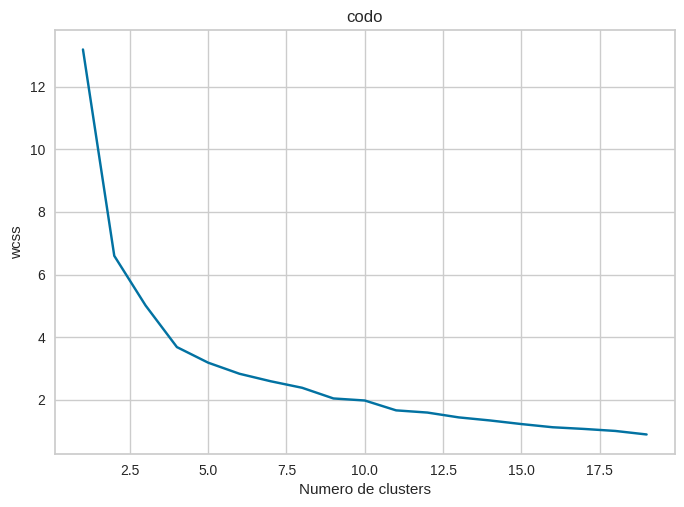

In [136]:
wcss = [] # Almacenamos los valores generados por los individuos mas cercanos entre si (WCSS = within cluster sum of square)

for i in range(1,20):
  kmeans = KMeans(n_clusters = i, max_iter = 300)
  kmeans.fit(df_normalizado)
  wcss.append(kmeans.inertia_)

plt.plot(range(1,20), wcss)
plt.title('codo')
plt.xlabel('Numero de clusters')
plt.ylabel('wcss')
plt.show()

Para determinar el k optimo tambien utilizaremos una libreria como KElbowVisualizer

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

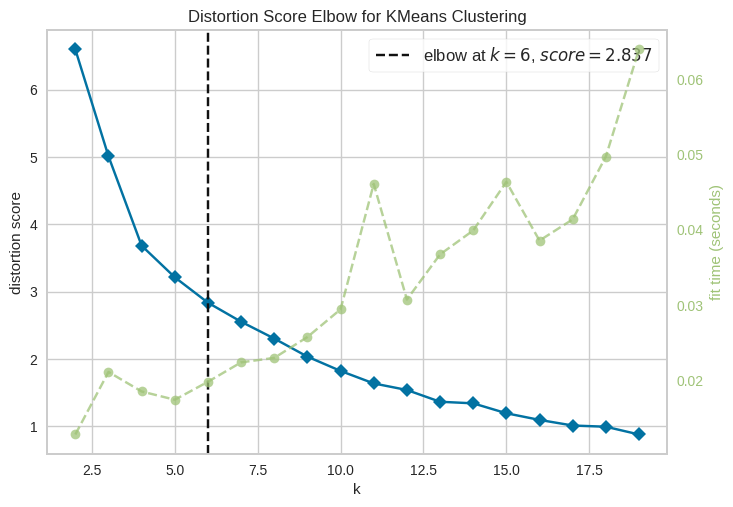

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [137]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(df_normalizado.loc[:,:])
elbow.show()

Ahora si, creamos el modelo y lo entrenamos con nuestro dataset

In [138]:
k = elbow.elbow_value_

In [139]:
kmeans = KMeans(n_clusters = 5, max_iter = 300, random_state=13) # Tomamos el valor de k de la iteracion previa
kmeans.fit(df_normalizado)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=13)

Ahora que tenemos los grupos armados, podemos agregarlos a nuestro dataset esos grupos creados para determinar a que grupo pertenece cada Estado

In [140]:
df['KMean_Cluster'] = kmeans.labels_ # Los resultados del kmeans se guardan mediante su metodo labels_
df.head()

,Estado,Asesinatos,Asaltos,Poblacion Urbana,Violaciones,KMean_Cluster
0,Alabama,13.2,236,58,21.2,4
1,Alaska,10.0,263,48,44.5,1
2,Arizona,8.1,294,80,31.0,1
3,Arkansas,8.8,190,50,19.5,3
4,California,9.0,276,91,40.6,1


Ya que tenemos varias caracteristicas que corresponden a nuestros grupos, no podemos graficarlas pero utilizaremos una funcion de sklearn que nos permitira generar dos componentes similares que agrupan estas caracteristicas, solo para dar una visualizacion a nuestros resultados

In [141]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_df = pca.fit_transform(df[['Asesinatos','Asaltos','Poblacion Urbana','Violaciones']])
pca_df = pd.DataFrame(data = pca_df, columns = ['Agrupacion_1', 'Agrupacion_2'])
pca_grupos = pd.concat([pca_df, df[['KMean_Cluster']]], axis=1)

pca_grupos.head()

,Agrupacion_1,Agrupacion_2,KMean_Cluster
0,64.802164,11.448007,4
1,92.827450,17.982943,1
2,124.068216,-8.830403,1
3,18.340035,16.703911,3
4,107.422953,-22.520070,1


Ahora que tenemos solamente dos agrupaciones principales y su cluster en si, podemos realizar un grafico

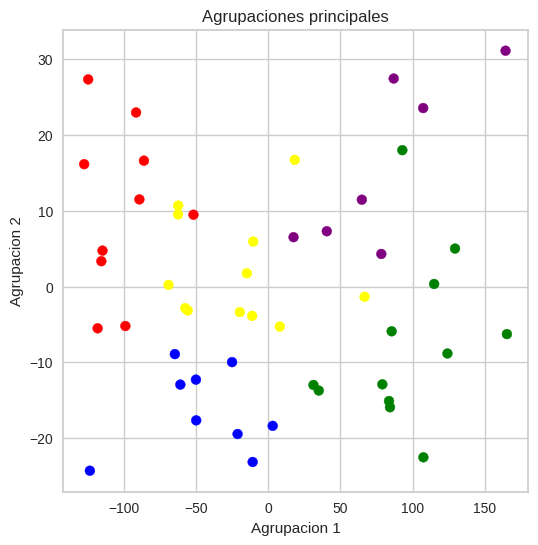

In [142]:
fig = plt.figure(figsize = (6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Agrupacion 1')
ax.set_ylabel('Agrupacion 2')
ax.set_title('Agrupaciones principales')

colores = np.array(['blue','green','red','yellow','purple'])
ax.scatter(x = pca_grupos.Agrupacion_1, y = pca_grupos.Agrupacion_2, c=colores[pca_grupos.KMean_Cluster], s=50)

plt.show()

*ACLARACION: Pueden darse errores en el grafico PCA ya que hace aproximaciones en el agrupamiento de las caracteristicas, por eso puede haber puntos en lugares inesperados*

Y podemos saber cuales son los Estados de mayor riesgo

In [143]:
df.groupby('KMean_Cluster').agg(np.mean)

<ipython-input-143-f65eaec44d14>:1: FutureWarning: The operation <function mean at 0x7e20b99184c0> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df.groupby('KMean_Cluster').agg(np.mean)


,Asesinatos,Asaltos,Poblacion Urbana,Violaciones
KMean_Cluster,,,,
0,4.955556,125.444444,80.111111,17.788889
1,10.966667,264.000000,76.500000,33.608333
2,2.680000,70.100000,51.000000,10.910000
3,6.975000,148.416667,62.333333,19.775000
4,14.671429,251.285714,54.285714,21.685714


Graficamos para cada cluster de nuestro dataset, cada variacion de las diversas caracteristicas para saber cual de los grupos es el que almacena los Estados de mayor peligrosidad

<Axes: xlabel='KMean_Cluster', ylabel='Asesinatos'>

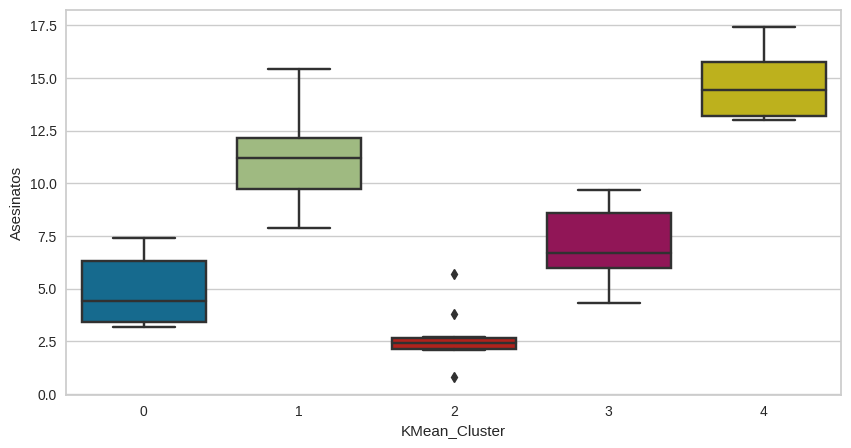

In [144]:
plt.figure(figsize=(10,5))
sns.boxplot(x='KMean_Cluster', y='Asesinatos', data=df)

<Axes: xlabel='KMean_Cluster', ylabel='Asaltos'>

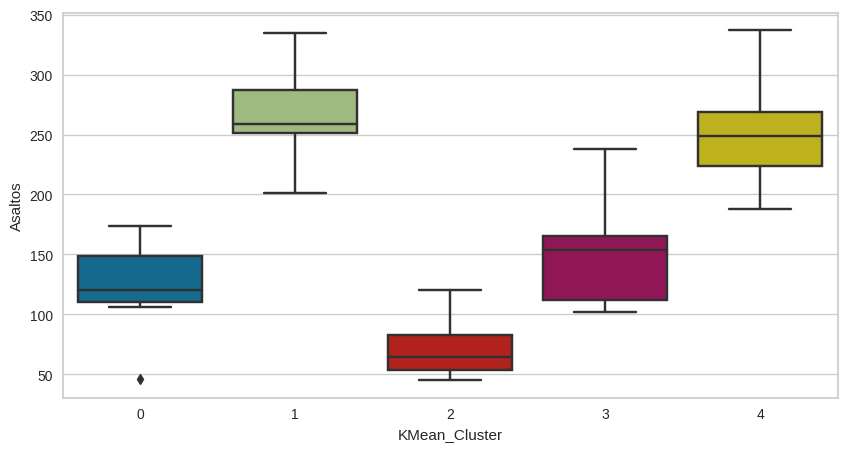

In [145]:
plt.figure(figsize=(10,5))
sns.boxplot(x='KMean_Cluster', y='Asaltos', data=df)

<Axes: xlabel='KMean_Cluster', ylabel='Violaciones'>

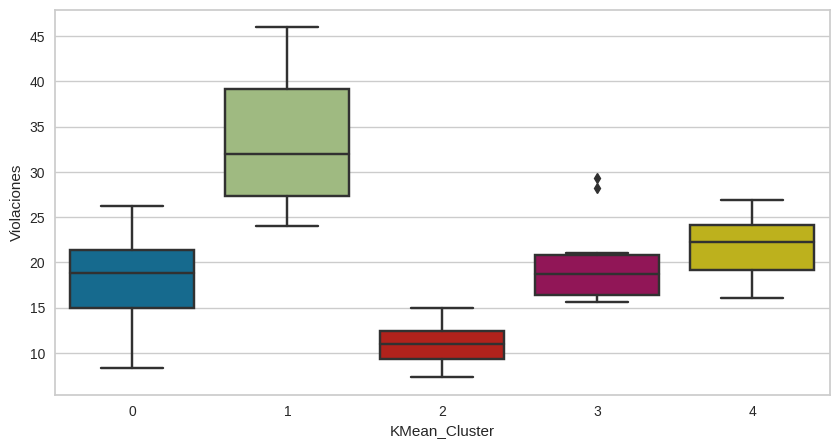

In [146]:
plt.figure(figsize=(10,5))
sns.boxplot(x='KMean_Cluster', y='Violaciones', data=df)

En base al analisis anterior podemos determinar que el grupo con mayores indices de peligrosidad es el grupo Nº1, en base a los valores promedios de las caracteristicas propias del grupo:
* 0 = Poco peligroso
* 1 = Extremadamente peligroso
* 2 = Normal
* 3 = Peligroso
* 4 = Muy peligroso

In [149]:
estados_mayor_riesgo = df.loc[df['KMean_Cluster'] == 1]

estados_mayor_riesgo

,Estado,Asesinatos,Asaltos,Poblacion Urbana,Violaciones,KMean_Cluster
1,Alaska,10.0,263,48,44.5,1
2,Arizona,8.1,294,80,31.0,1
4,California,9.0,276,91,40.6,1
5,Colorado,7.9,204,78,38.7,1
8,Florida,15.4,335,80,31.9,1
12,Illinois,10.4,249,83,24.0,1
19,Maryland,11.3,300,67,27.8,1
21,Michigan,12.1,255,74,35.1,1
27,Nevada,12.2,252,81,46.0,1
30,New Mexico,11.4,285,70,32.1,1
